# VGG-19 VS RESNET-50 - TRANSFER LEARNING
### USING A FC-LAYER ON VGG-19 AND RESNET-50 TRAINED ON IMAGENET
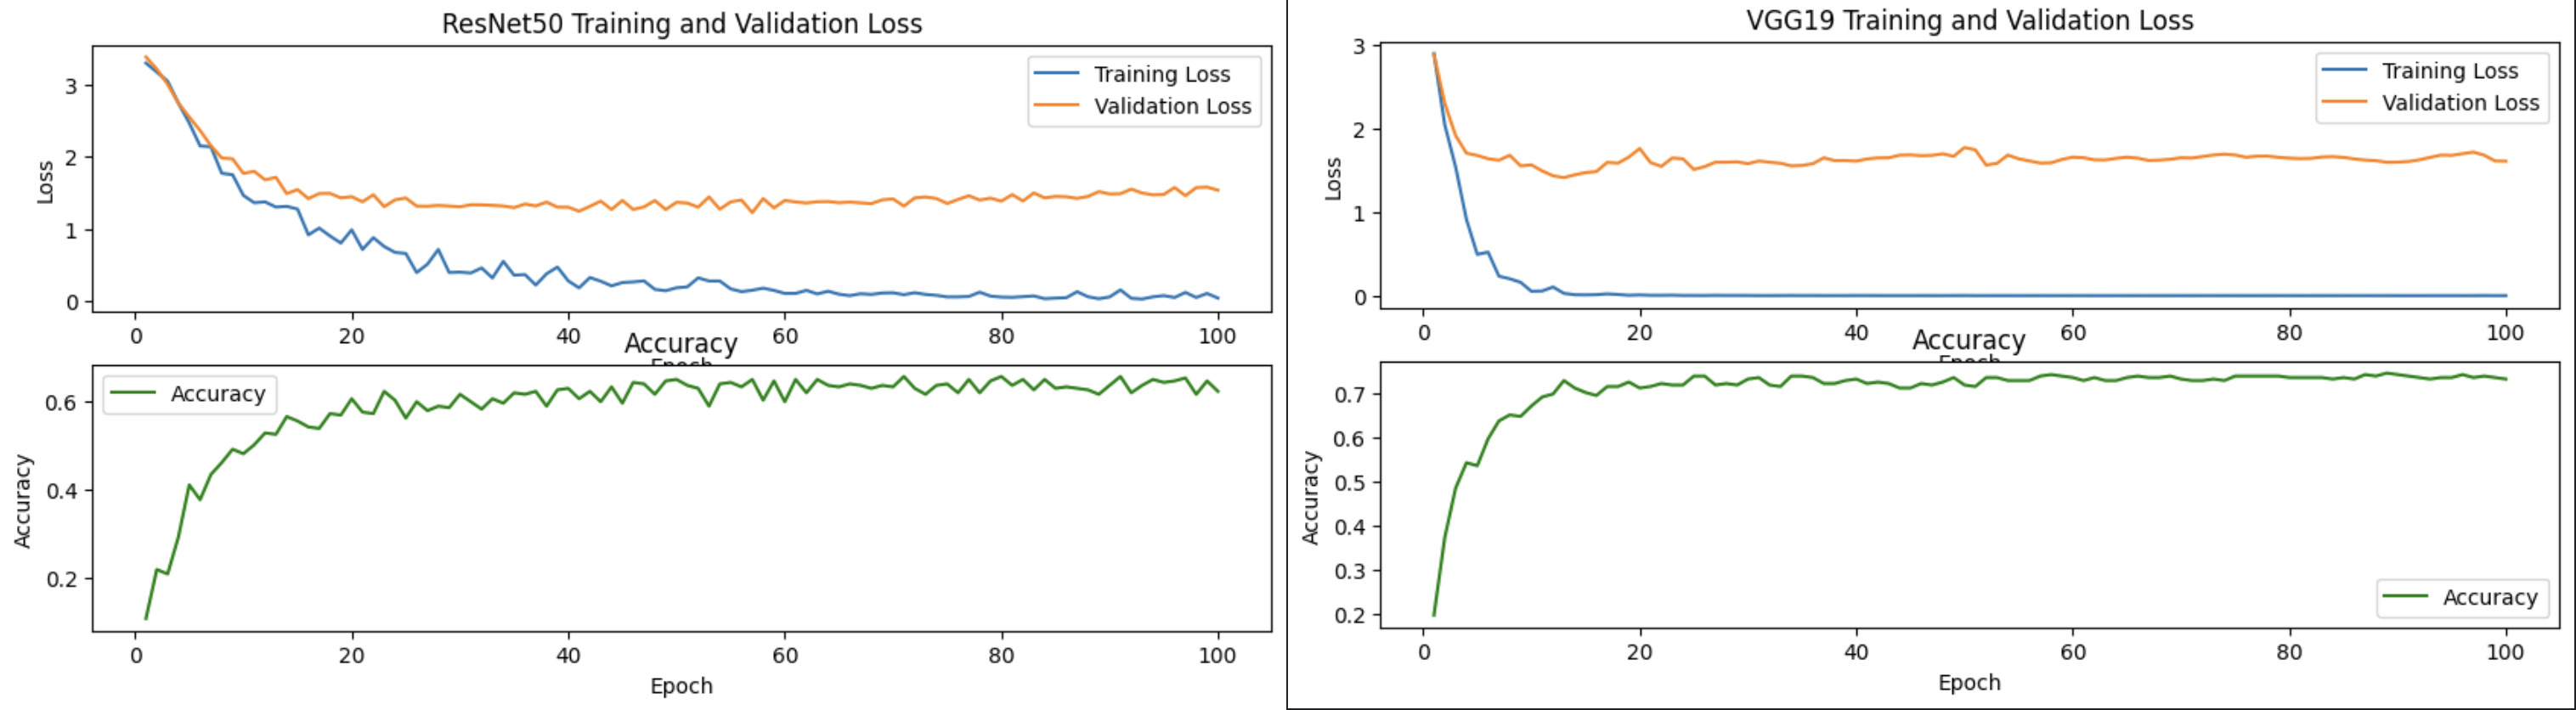
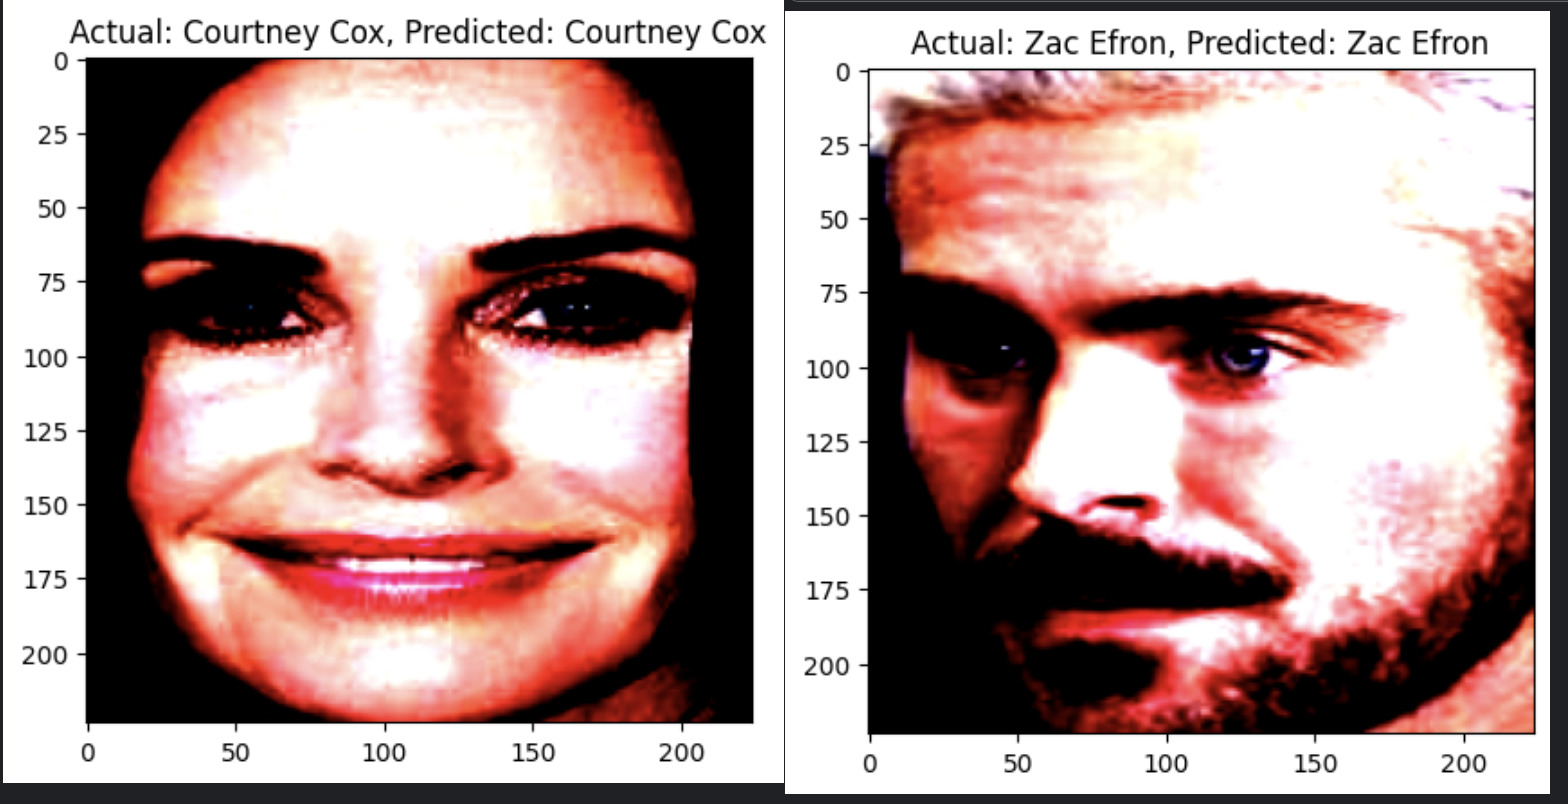

In [1]:
import numpy as np
import pandas as pd
import sklearn
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torchvision.models import vgg19
vgg_net = vgg19(pretrained=True)
import tqdm
from tqdm import tqdm

/usr/local/lib/python3.8/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## InceptionResentV1

In [2]:
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split, SubsetRandomSampler
from torchvision.datasets import ImageFolder
from sklearn.model_selection import train_test_split



import torchvision.transforms.functional as F
from PIL import Image
import random

class RandomDownscaleUpscale:
    def __init__(self, scale_range=(0.5, 1.0)):
        assert isinstance(scale_range, (tuple, list)) and len(scale_range) == 2
        self.scale_range = scale_range

    def __call__(self, img):
        scale_factor = random.uniform(*self.scale_range)
        downscaled_size = (int(img.width * scale_factor), int(img.height * scale_factor))
        downscaled_img = F.resize(img, downscaled_size, interpolation=Image.BILINEAR)
        upscaled_img = F.resize(downscaled_img, img.size, interpolation=Image.BILINEAR)
        return upscaled_img


transform = transforms.Compose([
    RandomDownscaleUpscale(scale_range=(0.5, 1.0)),  # Randomly downscale and then upscale the image
    transforms.Resize((224, 224)),  # Randomly crop the image to 224x224 and resize
    transforms.RandomRotation(degrees=15),  # Randomly rotate the image by up to 15 degrees
    transforms.RandomHorizontalFlip(),  # Randomly flip the image horizontally
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),  # Randomly change the brightness, contrast, saturation, and hue
    transforms.ToTensor(),  # Convert the image to a tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Normalize the tensor
])

# transform = transforms.Compose([
#     transforms.Resize((224, 224)), 
#     transforms.ToTensor(),
#     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),

# ])

model_name = "resnet_model_data_augmentation.pth"
data_dir = '/home/bishal/demoprojects/facerecognition/Datasets/Faces'
learning_rate = 5e-5 # 1e-4


dataset = ImageFolder(root=data_dir, transform=transform)

# train_size = int(0.8 * len(dataset))
# val_size = len(dataset) - train_size
# train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
# train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
# val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

targets = np.array(dataset.targets)
print(targets)

# Split indices for each class proportionally
train_indices = []
val_indices = []

for class_idx in np.unique(targets):
    class_indices = np.where(targets == class_idx)[0]
    train_class_indices, val_class_indices = train_test_split(class_indices, test_size=0.2, random_state=42)
    train_indices.extend(train_class_indices)
    val_indices.extend(val_class_indices)

# Create the samplers
train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)

# Create the data loaders
train_loader = DataLoader(dataset, batch_size=16, sampler=train_sampler)
val_loader = DataLoader(dataset, batch_size=16, sampler=val_sampler)

# Verify the distribution
train_targets = [dataset.targets[i] for i in train_indices]
val_targets = [dataset.targets[i] for i in val_indices]

print("Training set class distribution:", np.bincount(train_targets))
print("Validation set class distribution:", np.bincount(val_targets))


FileNotFoundError: [Errno 2] No such file or directory: '/home/bishal/demoprojects/facerecognition/Datasets/Faces'

In [ ]:
from facenet_pytorch import MTCNN, InceptionResnetV1


device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
resnet = InceptionResnetV1(pretrained='vggface2', classify = True, num_classes=len(dataset.classes))
resnet

InceptionResnetV1(
  (conv2d_1a): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (conv2d_2a): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (conv2d_2b): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (maxpool_3a): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2d_3b): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (conv2d_4a): 

In [ ]:

state_dict = resnet.state_dict()

# Print the names of the layers
print("Layers in the model:")
for layer_name in state_dict.keys():
    print(layer_name)

# Inspect weights of a specific layer, for example, the first convolutional layer
conv1_weights = state_dict['last_linear.weight']
print(conv1_weights)

Layers in the model:
conv2d_1a.conv.weight
conv2d_1a.bn.weight
conv2d_1a.bn.bias
conv2d_1a.bn.running_mean
conv2d_1a.bn.running_var
conv2d_1a.bn.num_batches_tracked
conv2d_2a.conv.weight
conv2d_2a.bn.weight
conv2d_2a.bn.bias
conv2d_2a.bn.running_mean
conv2d_2a.bn.running_var
conv2d_2a.bn.num_batches_tracked
conv2d_2b.conv.weight
conv2d_2b.bn.weight
conv2d_2b.bn.bias
conv2d_2b.bn.running_mean
conv2d_2b.bn.running_var
conv2d_2b.bn.num_batches_tracked
conv2d_3b.conv.weight
conv2d_3b.bn.weight
conv2d_3b.bn.bias
conv2d_3b.bn.running_mean
conv2d_3b.bn.running_var
conv2d_3b.bn.num_batches_tracked
conv2d_4a.conv.weight
conv2d_4a.bn.weight
conv2d_4a.bn.bias
conv2d_4a.bn.running_mean
conv2d_4a.bn.running_var
conv2d_4a.bn.num_batches_tracked
conv2d_4b.conv.weight
conv2d_4b.bn.weight
conv2d_4b.bn.bias
conv2d_4b.bn.running_mean
conv2d_4b.bn.running_var
conv2d_4b.bn.num_batches_tracked
repeat_1.0.branch0.conv.weight
repeat_1.0.branch0.bn.weight
repeat_1.0.branch0.bn.bias
repeat_1.0.branch0.bn.runnin

In [ ]:
#    [ 0.0047, -0.0180, -0.0169,  ...,  0.0503,  0.0215,  0.0103],
#         [ 0.0060,  0.0189, -0.0225,  ..., -0.0147,  0.0075,  0.0285],
#         [ 0.0375,  0.0080, -0.0308,  ...,  0.0367,  0.0274,  0.0437]])


#     [-5.9108e-04, -9.3956e-03,  2.1166e-03,  ...,  7.5513e-03,
#          -4.0517e-03,  4.0813e-03],
#         [-5.3783e-03, -7.4705e-03,  2.0598e-02,  ...,  4.0410e-03,
#           9.6714e-03,  2.1115e-02]])

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models

# Freeze all parameters
for param in resnet.parameters():
    param.requires_grad = False

# Unfreeze the last layer (fully connected layer)
for param in resnet.logits.parameters():
    param.requires_grad = True

# Print the status of requires_grad for each parameter
for name, param in resnet.named_parameters():
    print(f"{name}: requires_grad={param.requires_grad}")

# resnet.features.

conv2d_1a.conv.weight: requires_grad=False
conv2d_1a.bn.weight: requires_grad=False
conv2d_1a.bn.bias: requires_grad=False
conv2d_2a.conv.weight: requires_grad=False
conv2d_2a.bn.weight: requires_grad=False
conv2d_2a.bn.bias: requires_grad=False
conv2d_2b.conv.weight: requires_grad=False
conv2d_2b.bn.weight: requires_grad=False
conv2d_2b.bn.bias: requires_grad=False
conv2d_3b.conv.weight: requires_grad=False
conv2d_3b.bn.weight: requires_grad=False
conv2d_3b.bn.bias: requires_grad=False
conv2d_4a.conv.weight: requires_grad=False
conv2d_4a.bn.weight: requires_grad=False
conv2d_4a.bn.bias: requires_grad=False
conv2d_4b.conv.weight: requires_grad=False
conv2d_4b.bn.weight: requires_grad=False
conv2d_4b.bn.bias: requires_grad=False
repeat_1.0.branch0.conv.weight: requires_grad=False
repeat_1.0.branch0.bn.weight: requires_grad=False
repeat_1.0.branch0.bn.bias: requires_grad=False
repeat_1.0.branch1.0.conv.weight: requires_grad=False
repeat_1.0.branch1.0.bn.weight: requires_grad=False
repeat

### TRAINING InceptionResnetv1

In [ ]:

num_classes = len(dataset.classes)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet.parameters(), lr=learning_rate) # 1e-4

num_epochs = 100
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
resnet.to(device)
print(device)

vgg_training_logs =[]
for epoch in tqdm(range(num_epochs)):
    epoch_log={}
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = resnet(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

    with torch.no_grad():
        resnet.eval()
        total_correct = 0
        total_samples = 0

        for val_inputs, val_labels in val_loader:
            val_inputs, val_labels = val_inputs.to(device), val_labels.to(device)
            val_outputs = resnet(val_inputs)
            val_loss = criterion(val_outputs, val_labels)

            # accuracy
            _, predicted = torch.max(val_outputs, 1)
            total_correct += (predicted == val_labels).sum().item()
            total_samples += val_labels.size(0)

        accuracy = total_correct / total_samples

    resnet.train() 

    print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {loss.item()}, Validation Loss: {val_loss.item()}, Accuracy: {accuracy * 100:.2f}%')
    epoch_log['Loss'] =loss.item()
    epoch_log['Validation Loss'] = val_loss.item()
    epoch_log['accuracy'] = accuracy
    
    vgg_training_logs.append(epoch_log)

torch.save(resnet.state_dict(), model_name)


cuda


  0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.8/dist-packages/torchvision/transforms/functional.py:364: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  warnings.warn(
  1%|          | 1/100 [00:12<20:07, 12.20s/it]

Epoch 1/100, Loss: 3.1461856365203857, Validation Loss: 3.2683746814727783, Accuracy: 12.87%


  2%|▏         | 2/100 [00:22<18:05, 11.08s/it]

Epoch 2/100, Loss: 2.858715295791626, Validation Loss: 2.78973388671875, Accuracy: 35.64%


  3%|▎         | 3/100 [00:31<16:19, 10.10s/it]

Epoch 3/100, Loss: 2.4578511714935303, Validation Loss: 2.263817310333252, Accuracy: 51.82%


  4%|▍         | 4/100 [00:40<15:32,  9.72s/it]

Epoch 4/100, Loss: 2.338904619216919, Validation Loss: 2.022963762283325, Accuracy: 67.99%


  5%|▌         | 5/100 [00:49<14:52,  9.40s/it]

Epoch 5/100, Loss: 1.9397233724594116, Validation Loss: 2.155789852142334, Accuracy: 76.90%


  6%|▌         | 6/100 [00:59<14:53,  9.51s/it]

Epoch 6/100, Loss: 1.9359511137008667, Validation Loss: 1.4774086475372314, Accuracy: 83.83%


  7%|▋         | 7/100 [01:08<14:53,  9.61s/it]

Epoch 7/100, Loss: 1.4138950109481812, Validation Loss: 1.686323881149292, Accuracy: 81.85%


  8%|▊         | 8/100 [01:18<14:34,  9.50s/it]

Epoch 8/100, Loss: 1.2758474349975586, Validation Loss: 1.1757241487503052, Accuracy: 88.45%


  9%|▉         | 9/100 [01:27<14:23,  9.48s/it]

Epoch 9/100, Loss: 1.532984733581543, Validation Loss: 1.0477148294448853, Accuracy: 88.45%


 10%|█         | 10/100 [01:36<13:59,  9.32s/it]

Epoch 10/100, Loss: 1.2300019264221191, Validation Loss: 0.9466458559036255, Accuracy: 89.11%


 11%|█         | 11/100 [01:45<13:50,  9.33s/it]

Epoch 11/100, Loss: 1.2165272235870361, Validation Loss: 1.0237221717834473, Accuracy: 91.09%


 12%|█▏        | 12/100 [01:54<13:29,  9.20s/it]

Epoch 12/100, Loss: 0.9184322953224182, Validation Loss: 0.7215944528579712, Accuracy: 91.09%


 13%|█▎        | 13/100 [02:03<13:12,  9.11s/it]

Epoch 13/100, Loss: 0.8815958499908447, Validation Loss: 0.7990998029708862, Accuracy: 91.09%


 14%|█▍        | 14/100 [02:13<13:09,  9.18s/it]

Epoch 14/100, Loss: 1.1073484420776367, Validation Loss: 0.7332358956336975, Accuracy: 92.41%


 15%|█▌        | 15/100 [02:24<13:50,  9.77s/it]

Epoch 15/100, Loss: 0.6096227765083313, Validation Loss: 0.8520588278770447, Accuracy: 92.41%


 16%|█▌        | 16/100 [02:33<13:39,  9.75s/it]

Epoch 16/100, Loss: 0.6649468541145325, Validation Loss: 0.7094156742095947, Accuracy: 91.75%


 17%|█▋        | 17/100 [02:43<13:16,  9.60s/it]

Epoch 17/100, Loss: 0.9857244491577148, Validation Loss: 0.38316693902015686, Accuracy: 93.40%


 18%|█▊        | 18/100 [02:52<12:59,  9.50s/it]

Epoch 18/100, Loss: 0.39138904213905334, Validation Loss: 1.1574114561080933, Accuracy: 91.75%


 19%|█▉        | 19/100 [03:01<12:40,  9.39s/it]

Epoch 19/100, Loss: 0.6148176193237305, Validation Loss: 0.6937909722328186, Accuracy: 93.73%


 20%|██        | 20/100 [03:10<12:27,  9.35s/it]

Epoch 20/100, Loss: 0.5729153752326965, Validation Loss: 0.38520917296409607, Accuracy: 92.41%


 21%|██        | 21/100 [03:20<12:16,  9.32s/it]

Epoch 21/100, Loss: 0.30114346742630005, Validation Loss: 0.6499961614608765, Accuracy: 90.43%


 22%|██▏       | 22/100 [03:28<11:56,  9.19s/it]

Epoch 22/100, Loss: 0.8893675208091736, Validation Loss: 0.6296697854995728, Accuracy: 93.73%


 23%|██▎       | 23/100 [03:38<12:01,  9.37s/it]

Epoch 23/100, Loss: 0.6935761570930481, Validation Loss: 0.5123575329780579, Accuracy: 92.74%


 24%|██▍       | 24/100 [03:48<11:50,  9.35s/it]

Epoch 24/100, Loss: 0.3597790002822876, Validation Loss: 0.7096952795982361, Accuracy: 93.40%


 25%|██▌       | 25/100 [03:57<11:39,  9.33s/it]

Epoch 25/100, Loss: 0.48246049880981445, Validation Loss: 0.4933305084705353, Accuracy: 92.41%


 26%|██▌       | 26/100 [04:06<11:32,  9.36s/it]

Epoch 26/100, Loss: 0.41351208090782166, Validation Loss: 0.5405002236366272, Accuracy: 93.73%


 27%|██▋       | 27/100 [04:16<11:26,  9.41s/it]

Epoch 27/100, Loss: 0.2685081660747528, Validation Loss: 0.46163907647132874, Accuracy: 94.39%


 28%|██▊       | 28/100 [04:26<11:24,  9.51s/it]

Epoch 28/100, Loss: 0.4567050635814667, Validation Loss: 0.5167484879493713, Accuracy: 92.41%


 29%|██▉       | 29/100 [04:35<11:16,  9.53s/it]

Epoch 29/100, Loss: 0.6275784373283386, Validation Loss: 0.3589549958705902, Accuracy: 93.73%


 30%|███       | 30/100 [04:45<11:09,  9.57s/it]

Epoch 30/100, Loss: 0.23671086132526398, Validation Loss: 0.24114985764026642, Accuracy: 95.05%


 31%|███       | 31/100 [04:54<10:56,  9.51s/it]

Epoch 31/100, Loss: 0.49651381373405457, Validation Loss: 0.49049463868141174, Accuracy: 94.39%


 32%|███▏      | 32/100 [05:06<11:38, 10.27s/it]

Epoch 32/100, Loss: 0.5821976065635681, Validation Loss: 0.33589449524879456, Accuracy: 94.06%


 33%|███▎      | 33/100 [05:45<20:51, 18.68s/it]

Epoch 33/100, Loss: 0.28655505180358887, Validation Loss: 0.5836065411567688, Accuracy: 94.39%


 34%|███▍      | 34/100 [06:37<31:36, 28.74s/it]

Epoch 34/100, Loss: 0.12865367531776428, Validation Loss: 0.38228556513786316, Accuracy: 93.40%


 35%|███▌      | 35/100 [07:20<35:57, 33.20s/it]

Epoch 35/100, Loss: 0.3196699917316437, Validation Loss: 0.4879476726055145, Accuracy: 93.40%


 36%|███▌      | 36/100 [07:59<37:00, 34.69s/it]

Epoch 36/100, Loss: 0.22814710438251495, Validation Loss: 0.282064825296402, Accuracy: 92.08%


 37%|███▋      | 37/100 [08:41<38:51, 37.01s/it]

Epoch 37/100, Loss: 0.15191617608070374, Validation Loss: 0.40603503584861755, Accuracy: 92.41%


 38%|███▊      | 38/100 [09:24<40:13, 38.93s/it]

Epoch 38/100, Loss: 0.25669345259666443, Validation Loss: 0.4064793288707733, Accuracy: 95.38%


 39%|███▉      | 39/100 [10:01<39:00, 38.38s/it]

Epoch 39/100, Loss: 0.18436534702777863, Validation Loss: 0.4070335924625397, Accuracy: 94.72%


 40%|████      | 40/100 [10:28<34:51, 34.85s/it]

Epoch 40/100, Loss: 0.8667993545532227, Validation Loss: 0.46790555119514465, Accuracy: 94.06%


 41%|████      | 41/100 [10:38<26:55, 27.39s/it]

Epoch 41/100, Loss: 0.27313587069511414, Validation Loss: 0.27332067489624023, Accuracy: 95.38%


 42%|████▏     | 42/100 [10:47<21:02, 21.76s/it]

Epoch 42/100, Loss: 0.20035694539546967, Validation Loss: 0.23202896118164062, Accuracy: 94.72%


 43%|████▎     | 43/100 [10:57<17:20, 18.25s/it]

Epoch 43/100, Loss: 0.4633292853832245, Validation Loss: 0.16220876574516296, Accuracy: 94.39%


 44%|████▍     | 44/100 [11:06<14:39, 15.71s/it]

Epoch 44/100, Loss: 0.19307315349578857, Validation Loss: 0.4055515229701996, Accuracy: 92.41%


 45%|████▌     | 45/100 [11:16<12:47, 13.95s/it]

Epoch 45/100, Loss: 0.1641426384449005, Validation Loss: 0.093563511967659, Accuracy: 93.40%


 46%|████▌     | 46/100 [11:25<11:06, 12.35s/it]

Epoch 46/100, Loss: 0.22936059534549713, Validation Loss: 0.22933782637119293, Accuracy: 91.75%


 47%|████▋     | 47/100 [11:34<09:56, 11.25s/it]

Epoch 47/100, Loss: 0.44497212767601013, Validation Loss: 0.24638722836971283, Accuracy: 93.07%


 48%|████▊     | 48/100 [11:42<09:04, 10.47s/it]

Epoch 48/100, Loss: 0.11345240473747253, Validation Loss: 0.6567962169647217, Accuracy: 95.05%


 49%|████▉     | 49/100 [11:52<08:42, 10.25s/it]

Epoch 49/100, Loss: 0.6792094707489014, Validation Loss: 0.5719069242477417, Accuracy: 92.41%


 50%|█████     | 50/100 [12:01<08:11,  9.83s/it]

Epoch 50/100, Loss: 0.2409106343984604, Validation Loss: 0.1266365945339203, Accuracy: 94.39%


 51%|█████     | 51/100 [12:09<07:35,  9.29s/it]

Epoch 51/100, Loss: 0.2694028913974762, Validation Loss: 0.5720797181129456, Accuracy: 94.06%


 52%|█████▏    | 52/100 [12:17<07:12,  9.01s/it]

Epoch 52/100, Loss: 0.2719951570034027, Validation Loss: 0.2458365112543106, Accuracy: 95.05%


 53%|█████▎    | 53/100 [12:27<07:10,  9.16s/it]

Epoch 53/100, Loss: 0.12014744430780411, Validation Loss: 0.24008819460868835, Accuracy: 93.07%


 54%|█████▍    | 54/100 [12:36<07:06,  9.27s/it]

Epoch 54/100, Loss: 0.3385526239871979, Validation Loss: 0.09843547642230988, Accuracy: 94.72%


 55%|█████▌    | 55/100 [12:46<06:59,  9.32s/it]

Epoch 55/100, Loss: 0.48689910769462585, Validation Loss: 0.12770216166973114, Accuracy: 95.05%


 56%|█████▌    | 56/100 [12:56<07:00,  9.56s/it]

Epoch 56/100, Loss: 0.07769113779067993, Validation Loss: 0.2818881869316101, Accuracy: 94.72%


 57%|█████▋    | 57/100 [13:06<07:01,  9.80s/it]

Epoch 57/100, Loss: 0.2686598002910614, Validation Loss: 0.06371510028839111, Accuracy: 94.72%


 58%|█████▊    | 58/100 [13:16<06:51,  9.79s/it]

Epoch 58/100, Loss: 0.20914767682552338, Validation Loss: 0.5183635950088501, Accuracy: 94.06%


 59%|█████▉    | 59/100 [13:25<06:35,  9.65s/it]

Epoch 59/100, Loss: 0.17637425661087036, Validation Loss: 0.49681660532951355, Accuracy: 94.39%


 60%|██████    | 60/100 [13:38<07:01, 10.53s/it]

Epoch 60/100, Loss: 0.249699667096138, Validation Loss: 0.13576273620128632, Accuracy: 93.40%


 61%|██████    | 61/100 [14:13<11:41, 17.99s/it]

Epoch 61/100, Loss: 0.037671204656362534, Validation Loss: 0.3100285232067108, Accuracy: 95.05%


 62%|██████▏   | 62/100 [14:55<15:56, 25.18s/it]

Epoch 62/100, Loss: 0.4095832407474518, Validation Loss: 0.18931174278259277, Accuracy: 95.38%


 63%|██████▎   | 63/100 [15:36<18:28, 29.95s/it]

Epoch 63/100, Loss: 0.18146951496601105, Validation Loss: 0.3826081454753876, Accuracy: 92.08%


 64%|██████▍   | 64/100 [16:17<19:54, 33.18s/it]

Epoch 64/100, Loss: 0.13180135190486908, Validation Loss: 0.24748188257217407, Accuracy: 95.71%


 65%|██████▌   | 65/100 [17:01<21:09, 36.28s/it]

Epoch 65/100, Loss: 0.06430236250162125, Validation Loss: 0.27819427847862244, Accuracy: 95.71%


 66%|██████▌   | 66/100 [17:45<21:59, 38.80s/it]

Epoch 66/100, Loss: 0.5736622214317322, Validation Loss: 0.7291686534881592, Accuracy: 94.06%


 67%|██████▋   | 67/100 [18:25<21:27, 39.03s/it]

Epoch 67/100, Loss: 0.3054467439651489, Validation Loss: 0.6525022983551025, Accuracy: 95.71%


 68%|██████▊   | 68/100 [19:01<20:20, 38.14s/it]

Epoch 68/100, Loss: 0.14350612461566925, Validation Loss: 0.0671829953789711, Accuracy: 93.73%


 69%|██████▉   | 69/100 [19:37<19:26, 37.61s/it]

Epoch 69/100, Loss: 0.35845673084259033, Validation Loss: 0.1393173336982727, Accuracy: 94.06%


 70%|███████   | 70/100 [20:13<18:32, 37.08s/it]

Epoch 70/100, Loss: 0.2664976119995117, Validation Loss: 0.36273619532585144, Accuracy: 95.05%


 71%|███████   | 71/100 [20:48<17:33, 36.31s/it]

Epoch 71/100, Loss: 0.4192602336406708, Validation Loss: 0.13890379667282104, Accuracy: 96.04%


 72%|███████▏  | 72/100 [21:22<16:38, 35.64s/it]

Epoch 72/100, Loss: 0.4014061689376831, Validation Loss: 0.07887933403253555, Accuracy: 95.38%


 73%|███████▎  | 73/100 [22:00<16:23, 36.43s/it]

Epoch 73/100, Loss: 0.17484499514102936, Validation Loss: 0.04285111278295517, Accuracy: 93.07%


 74%|███████▍  | 74/100 [22:39<16:09, 37.30s/it]

Epoch 74/100, Loss: 0.08606565743684769, Validation Loss: 0.11590059101581573, Accuracy: 95.38%


 75%|███████▌  | 75/100 [23:18<15:45, 37.84s/it]

Epoch 75/100, Loss: 0.155897855758667, Validation Loss: 0.16070856153964996, Accuracy: 94.39%


 76%|███████▌  | 76/100 [23:57<15:10, 37.95s/it]

Epoch 76/100, Loss: 0.1331595480442047, Validation Loss: 0.11652687191963196, Accuracy: 95.38%


 77%|███████▋  | 77/100 [24:39<15:06, 39.41s/it]

Epoch 77/100, Loss: 0.26735177636146545, Validation Loss: 0.2593134045600891, Accuracy: 94.06%


 78%|███████▊  | 78/100 [25:24<15:03, 41.07s/it]

Epoch 78/100, Loss: 0.16235914826393127, Validation Loss: 0.2090088576078415, Accuracy: 92.41%


 79%|███████▉  | 79/100 [26:09<14:43, 42.05s/it]

Epoch 79/100, Loss: 0.5297006964683533, Validation Loss: 0.2233988642692566, Accuracy: 95.38%


 80%|████████  | 80/100 [26:46<13:29, 40.48s/it]

Epoch 80/100, Loss: 0.09555351734161377, Validation Loss: 0.4360080659389496, Accuracy: 93.73%


 81%|████████  | 81/100 [27:23<12:30, 39.52s/it]

Epoch 81/100, Loss: 0.060285534709692, Validation Loss: 0.27174413204193115, Accuracy: 95.05%


 82%|████████▏ | 82/100 [28:04<11:58, 39.90s/it]

Epoch 82/100, Loss: 0.12935125827789307, Validation Loss: 0.2993790805339813, Accuracy: 95.38%


 83%|████████▎ | 83/100 [28:51<11:54, 42.05s/it]

Epoch 83/100, Loss: 0.14354674518108368, Validation Loss: 0.04692286252975464, Accuracy: 93.40%


 84%|████████▍ | 84/100 [29:40<11:49, 44.36s/it]

Epoch 84/100, Loss: 0.21119458973407745, Validation Loss: 0.6456535458564758, Accuracy: 93.40%


 85%|████████▌ | 85/100 [30:38<12:07, 48.47s/it]

Epoch 85/100, Loss: 0.15337397158145905, Validation Loss: 0.2170301377773285, Accuracy: 93.73%


 86%|████████▌ | 86/100 [31:22<10:55, 46.85s/it]

Epoch 86/100, Loss: 0.12571489810943604, Validation Loss: 0.47102662920951843, Accuracy: 96.04%


 87%|████████▋ | 87/100 [32:06<10:00, 46.18s/it]

Epoch 87/100, Loss: 0.12346115708351135, Validation Loss: 0.3282720446586609, Accuracy: 94.06%


 88%|████████▊ | 88/100 [32:46<08:52, 44.35s/it]

Epoch 88/100, Loss: 0.42773059010505676, Validation Loss: 0.09933026880025864, Accuracy: 94.72%


 89%|████████▉ | 89/100 [33:30<08:04, 44.06s/it]

Epoch 89/100, Loss: 0.09832384437322617, Validation Loss: 0.10422961413860321, Accuracy: 94.72%


 90%|█████████ | 90/100 [34:16<07:26, 44.67s/it]

Epoch 90/100, Loss: 0.04599897190928459, Validation Loss: 0.6177456974983215, Accuracy: 95.71%


 91%|█████████ | 91/100 [34:54<06:26, 42.90s/it]

Epoch 91/100, Loss: 0.09048798680305481, Validation Loss: 0.13895508646965027, Accuracy: 93.40%


 92%|█████████▏| 92/100 [35:37<05:42, 42.78s/it]

Epoch 92/100, Loss: 0.3895989656448364, Validation Loss: 0.3337876498699188, Accuracy: 94.72%


 93%|█████████▎| 93/100 [36:15<04:50, 41.47s/it]

Epoch 93/100, Loss: 0.07158341258764267, Validation Loss: 0.8046785593032837, Accuracy: 95.38%


 94%|█████████▍| 94/100 [36:50<03:56, 39.38s/it]

Epoch 94/100, Loss: 0.03644976392388344, Validation Loss: 0.3786337673664093, Accuracy: 94.72%


 95%|█████████▌| 95/100 [37:35<03:25, 41.20s/it]

Epoch 95/100, Loss: 0.2885715663433075, Validation Loss: 0.3129774034023285, Accuracy: 96.04%


 96%|█████████▌| 96/100 [38:26<02:55, 43.99s/it]

Epoch 96/100, Loss: 0.1712104231119156, Validation Loss: 0.2658153772354126, Accuracy: 95.38%


 97%|█████████▋| 97/100 [39:09<02:11, 43.83s/it]

Epoch 97/100, Loss: 0.07834601402282715, Validation Loss: 0.057638656347990036, Accuracy: 94.72%


 98%|█████████▊| 98/100 [39:50<01:26, 43.01s/it]

Epoch 98/100, Loss: 0.06802574545145035, Validation Loss: 0.05677239969372749, Accuracy: 93.73%


 99%|█████████▉| 99/100 [40:37<00:44, 44.16s/it]

Epoch 99/100, Loss: 0.6560841798782349, Validation Loss: 0.46713072061538696, Accuracy: 94.39%


100%|██████████| 100/100 [41:20<00:00, 24.81s/it]

Epoch 100/100, Loss: 0.1206020712852478, Validation Loss: 0.2310921996831894, Accuracy: 95.38%


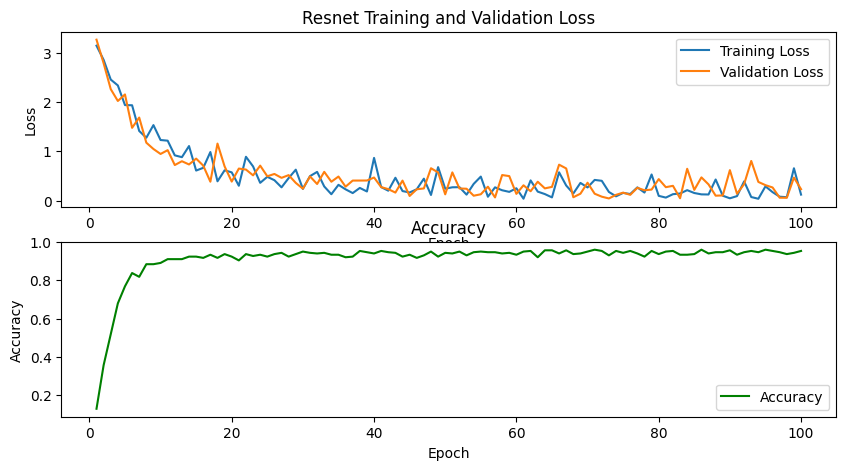

In [ ]:
import matplotlib.pyplot as plt
epochs = list(range(1, len(vgg_training_logs) + 1))
loss_values = [entry['Loss'] for entry in vgg_training_logs]
val_loss_values = [entry['Validation Loss'] for entry in vgg_training_logs]
accuracy_values = [entry['accuracy'] for entry in vgg_training_logs]

# Plotting
plt.figure(figsize=(10, 5))

# Plot Loss
plt.subplot(2, 1, 1)
plt.plot(epochs, loss_values, label='Training Loss')
plt.plot(epochs, val_loss_values, label='Validation Loss')
plt.title('Resnet Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot Accuracy
plt.subplot(2, 1, 2)
plt.plot(epochs, accuracy_values, label='Accuracy', color='green')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()


## CLASSIFICATION REPORT 

### Resnet

In [ ]:
import torch
from sklearn.metrics import classification_report

resnet.eval()

true_labels = []
predicted_labels = []
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
resnet.to(device)

with torch.no_grad():
    for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = resnet(inputs)

        _, predicted = torch.max(outputs, 1)

        true_labels.extend(labels.cpu().numpy())
        predicted_labels.extend(predicted.cpu().numpy())

true_labels = np.array(true_labels)
predicted_labels = np.array(predicted_labels)

class_names = dataset.classes
report = classification_report(true_labels, predicted_labels, target_names=class_names)

print(report)


/usr/local/lib/python3.8/dist-packages/torchvision/transforms/functional.py:364: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  warnings.warn(


                    precision    recall  f1-score   support

      Akshay Kumar       0.88      0.70      0.78        10
Alexandra Daddario       1.00      1.00      1.00        10
        Alia Bhatt       0.83      1.00      0.91        10
  Amitabh Bachchan       1.00      1.00      1.00        10
      Andy Samberg       1.00      0.90      0.95        10
    Anushka Sharma       1.00      1.00      1.00        10
     Billie Eilish       0.83      1.00      0.91        10
         Brad Pitt       1.00      1.00      1.00        10
    Camila Cabello       0.88      0.70      0.78        10
   Charlize Theron       1.00      1.00      1.00        10
       Claire Holt       1.00      0.90      0.95        10
      Courtney Cox       1.00      0.90      0.95        10
    Dwayne Johnson       0.83      1.00      0.91        10
   Elizabeth Olsen       1.00      1.00      1.00        10
   Ellen Degeneres       1.00      1.00      1.00        10
      Henry Cavill       1.00      0.90

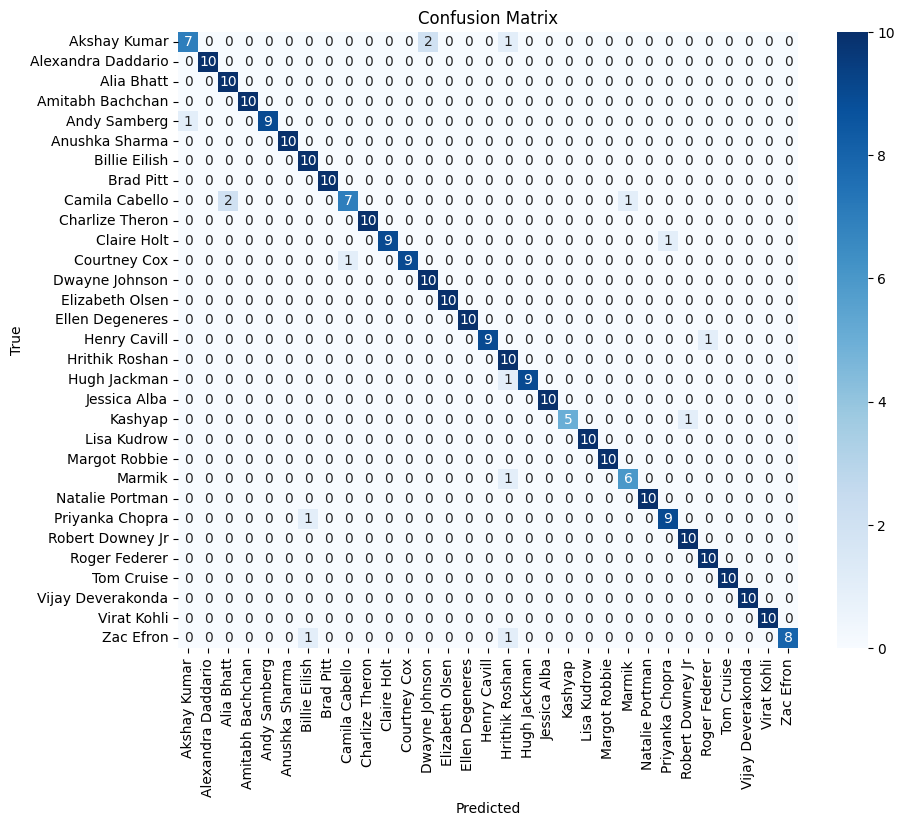

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

conf_matrix = confusion_matrix(true_labels, predicted_labels)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()